# Set-up the environment

In [ ]:
# NOTE: after 'Restart runtime', installed packages are maintained!
!pip install transformers
!pip install tensorflow-datasets
!pip install torchmetrics
!pip install pickle5
# !pip install matplotlib --upgrade # Runtime restart required

     |████████████████████████████████| 2.3MB 5.2MB/s 
     |████████████████████████████████| 3.3MB 27.3MB/s 
     |████████████████████████████████| 901kB 36.3MB/s 
     |████████████████████████████████| 276kB 6.5MB/s 
     |████████████████████████████████| 133kB 5.2MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219252 sha256=e29fe3987afbc28991ff0200ab8b042ff9ada197624b7e640e4561a158f960ef
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [ ]:
import torch
import numpy as np
import random
import csv
import os.path
import pandas as pd
import math
import torch.nn as nn

from torchmetrics import Accuracy

from transformers import BertTokenizer, BertModel
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup, get_polynomial_decay_schedule_with_warmup

from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
import tensorflow_datasets as tfds

import pickle5 as pickle

# We will mostly use dictionaries
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Used to store intermediate results
destination_folder = '/content/drive/MyDrive/thesis_data/'

In [ ]:
if torch.cuda.is_available(): 
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


# Generator and discriminator

This part is borrowed from https://github.com/crux82/ganbert-pytorch/blob/main/GANBERT_pytorch.ipynb

In [ ]:
#------------------------------
#   The Generator as in 
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
        super(Generator, self).__init__()
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

# Data

In [ ]:
class Trec_dataset(Dataset):
    def __init__(self, split, lab_ratio):
        
        file_name = split+'_'+str(lab_ratio)+'.csv'
        if os.path.isfile(file_name):
            print(file_name+' already created, skip pre-processing')
            self.data = pd.read_csv(file_name) 
        else:
            print(file_name+' not created, pre-processing...')
    
            self.tf_ds = tfds.load('trec', split=split, batch_size=-1)
        
            size = len(self.tf_ds[list(self.tf_ds.keys())[0]])
            lab_size = int(lab_ratio * size)

            l_u_ratio = 1 if lab_ratio == 1 else lab_size/(size - lab_size)
            balance = int(1/l_u_ratio)
            balance = int(math.log(balance, 2))
            if balance < 1:
                balance = 1

            with open(file_name, mode='w') as csv_file:
                writer = csv.writer(csv_file, delimiter=',')
                writer.writerow(['index', 'label-coarse', 'label-fine', 'text', 'label-mask'])

                k = 0
                for i in range(size):
                    l_c = self.tf_ds['label-coarse'].numpy()[i]
                    l_f = self.tf_ds['label-fine'].numpy()[i]
                    t = self.tf_ds['text'].numpy()[i]
                    if i < lab_size and lab_ratio < 1:
                        for j in range(int(balance)):
                            writer.writerow([k, l_c, l_f, t, 1])
                            k += 1
                    else:
                        writer.writerow([k, l_c, l_f, t, 0])
                        k += 1

            self.data = pd.read_csv(file_name)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        l_c = self.data['label-coarse'][idx]
        l_f = self.data['label-fine'][idx]
        t = self.data['text'][idx]
        m = self.data['label-mask'][idx]

        return {'label-coarse':l_c, 'label-fine':l_f, 'text':t, 'label-mask':m}

# Train and test

In [ ]:
torch.set_printoptions(profile="full")

In [ ]:
hidden_size = 768
noise_size = 100
epsilon = 1e-8
dropout_rate = 0.2

batch_size = 64 # In code rep. it's 64
epochs = 3
learning_rate = 5e-5 # In code rep. it's 5e-5 (TensorFlow and Pytorch)
seq_length = 64

warmup_proportion = 0.1
apply_scheduler = False

do_train_logging = True
log_interval = 1 # During training, losses will be recored each log_interval steps

num_runs = 1

lab_ratio = 0.02
label_type = 'label-fine' # label-fine or label-coarse
num_classes = 6 if label_type == 'label-coarse' else 50

In [ ]:
all_runs_results = list() # Accumulate test metrics of last epoch
for i_run in range(num_runs):
    print('################# RUN {} / {} #################'.format(i_run+1,num_runs))

    # Define models
    bert = BertModel.from_pretrained('bert-base-cased')
    generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=[hidden_size], dropout_rate=dropout_rate)
    discriminator = Discriminator(input_size=hidden_size, hidden_sizes=[hidden_size], num_labels=num_classes, dropout_rate=dropout_rate)
    # generator = bNAbs_GAN_generator(noise_size, hidden_size, 768)
    # discriminator = bNAbs_GAN_discriminator(768, hidden_size, num_classes + 1) # + 1 for real/fake

    # Tell pytorch to run the models on the selected device
    bert.to(device)
    generator.to(device)
    discriminator.to(device)

    bert_vars = [i for i in bert.parameters()]
    d_vars = bert_vars + [v for v in discriminator.parameters()]
    g_vars = [v for v in generator.parameters()]

    # Define optimizers
    d_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate, eps=1e-6)
    g_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate, eps=1e-6)

    # Define (pretrained) tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

    # Datasets (Question Classification from TF)
    ds_train = Trec_dataset('train', lab_ratio)
    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2)
    no_bat_train = len(dl_train)

    ds_val = Trec_dataset('test', 1)
    dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=2)
    no_bat_val = len(dl_val)

    if apply_scheduler:
        total_steps = no_bat_train * epochs
        warmup_steps = int(total_steps * warmup_proportion)

        # Define learning rate schedulars with built-in warmup
        d_scheduler = get_polynomial_decay_schedule_with_warmup(d_optimizer,num_warmup_steps=warmup_steps,num_training_steps=total_steps,lr_end=0,power=1)
        g_scheduler = get_polynomial_decay_schedule_with_warmup(g_optimizer,num_warmup_steps=warmup_steps,num_training_steps=total_steps,lr_end=0,power=1)

    # For logging
    all_train_losses = torch.empty((5,0), device=device)

    # Used metrics
    accuracy = Accuracy()

    for i in range(epochs):

        train_losses = torch.empty((5,0), device=device)

        bert.train()
        generator.train()
        discriminator.train()

        for idx, batch in enumerate(dl_train):
            
            ## 0. Prepare data

            text_list = list(batch['text'])

            x = tokenizer(text_list, padding='max_length', max_length=seq_length, truncation=True)

            input_ids = torch.tensor(x['input_ids'], device=device)
            # token_type_ids = torch.tensor(x['token_type_ids'], device=device)
            attention_mask = torch.tensor(x['attention_mask'], device=device)
            
            labels = batch[label_type].to(device)
            label_mask = batch['label-mask'].to(device).bool()

            noise = torch.rand((batch_size, noise_size), device=device)
            generator_output = generator(noise)

            # Use representation of CLS token as the sentence embedding. Vector has length 768
            bert_output = bert(input_ids, attention_mask)[-1] #token_type_ids
            
            D_real_features, D_real_logits, D_real_prob = discriminator(bert_output)
            D_fake_features, DU_fake_logits, DU_fake_prob = discriminator(generator_output)

            ## 1. Discriminator loss
            
            ## 1.1 Supervised loss

            logits = D_real_logits[:, 1:]
            probabilities = torch.nn.functional.softmax(logits, dim=-1)

            log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

            one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=num_classes)

            per_example_loss =  - torch.sum(one_hot_labels * log_probs, dim=-1)
            per_example_loss = torch.masked_select(per_example_loss, label_mask)
            
            labeled_example_count = torch.tensor(per_example_loss.size()[0], dtype=torch.float32)

            disc_loss_supervised = torch.divide(torch.sum(per_example_loss), torch.maximum(torch.tensor(1), labeled_example_count))

            ## 1.2 Unsupervised loss
            
            disc_loss_unsupervised = - torch.mean(torch.log(1 - D_real_prob[:, 0] + epsilon))
            
            disc_loss_generator = - torch.mean(torch.log(DU_fake_prob[:, 0] + epsilon))     
            
            ## 2. Generator loss

            ## 2.1 Use generator output

            gen_loss_generator = - torch.mean(torch.log(1 - DU_fake_prob[:, 0] + epsilon))

            # print('disc_loss_generator',disc_loss_generator)
            # print('gen_loss_generator',gen_loss_generator)
            # assert(1==0)
            ## 2.2 Feature matching

            gen_loss_feat_match = torch.mean(torch.square(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0))) # CHANGE

            # Optimization 

            disc_loss = disc_loss_supervised + disc_loss_unsupervised + disc_loss_generator
            gen_loss = gen_loss_generator + gen_loss_feat_match
            
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()

            gen_loss.backward(retain_graph=True)
            disc_loss.backward()
            
            d_optimizer.step()
            g_optimizer.step()
            
            if apply_scheduler:
                d_scheduler.step()
                g_scheduler.step()

            ## 3. Logging
            if do_train_logging and idx % log_interval == 0:
                tmp = torch.tensor((
                    disc_loss_supervised.detach(),
                    disc_loss_unsupervised.detach(),
                    disc_loss_generator.detach(),
                    gen_loss_generator.detach(),
                    gen_loss_feat_match.detach()
                    ),device=device)
                tmp.resize_((5, 1))
                train_losses = torch.cat((train_losses,tmp),1)

        all_train_losses = torch.cat((all_train_losses,train_losses),1)

        ## 3. Validation

        bert.eval()
        generator.eval()
        discriminator.eval()

        all_labels = list()
        all_preds = list()

        for batch in dl_val:

            text_list = list(batch['text'])
            
            x = tokenizer(text_list, padding='max_length', max_length=seq_length, truncation=True)

            input_ids = torch.tensor(x['input_ids'], device=device)
            # token_type_ids = torch.tensor(x['token_type_ids'], device=device)
            attention_mask = torch.tensor(x['attention_mask'], device=device)         
            
            labels = batch[label_type]

            with torch.no_grad():

                bert_output = bert(input_ids, attention_mask)[-1]
                D_real_features, D_real_logits, D_real_prob = discriminator(bert_output)
            
            logits = D_real_logits[:, 1:]
            # probabilities = torch.nn.functional.softmax(logits, dim=-1)
            
            _, pred_labels = torch.max(logits, dim=1)
            
            all_labels += labels.detach().cpu()
            all_preds += pred_labels.detach().cpu()

        all_preds = torch.stack(all_preds)
        all_labels = torch.stack(all_labels)

        acc = accuracy(all_preds, all_labels)
        
        print('| Epoch',i+1,'| Accuracy =',acc.item(),'\n')
        if i == epochs-1:
            all_runs_results.append(acc.item())

    save_obj(all_train_losses.tolist(),destination_folder+'TRAIN_STATISTICS_MY_GAN-BERT_qc_'+label_type+'_'+str(lab_ratio)+'_for_comparison')

print('| {} | {} | Average accuracy over all runs = {}'.format(label_type,lab_ratio,sum(all_runs_results)/len(all_runs_results)))

| Epoch 1 | Accuracy = 0.43799999356269836 

| Epoch 2 | Accuracy = 0.5120000243186951 

| Epoch 3 | Accuracy = 0.5600000023841858 

| label-fine | 0.02 | Average accuracy over all runs = 0.5600000023841858


* | label-fine | 0.01 | Average accuracy over all runs = 0.4219
* | label-fine | 0.02 | Average accuracy over all runs = 0.5403
* | label-fine | 0.05 | Average accuracy over all runs = 0.6915
* | label-fine | 0.1 | Average accuracy over all runs = 0.6871


---


* | label-coarse | 0.01 | Average accuracy over all runs = 0.5392
* | label-coarse | 0.02 | Average accuracy over all runs = 0.7720
* | label-coarse | 0.05 | Average accuracy over all runs = 0.8871
* | label-coarse | 0.1 | Average accuracy over all runs = 0.9424

# Visualize losses

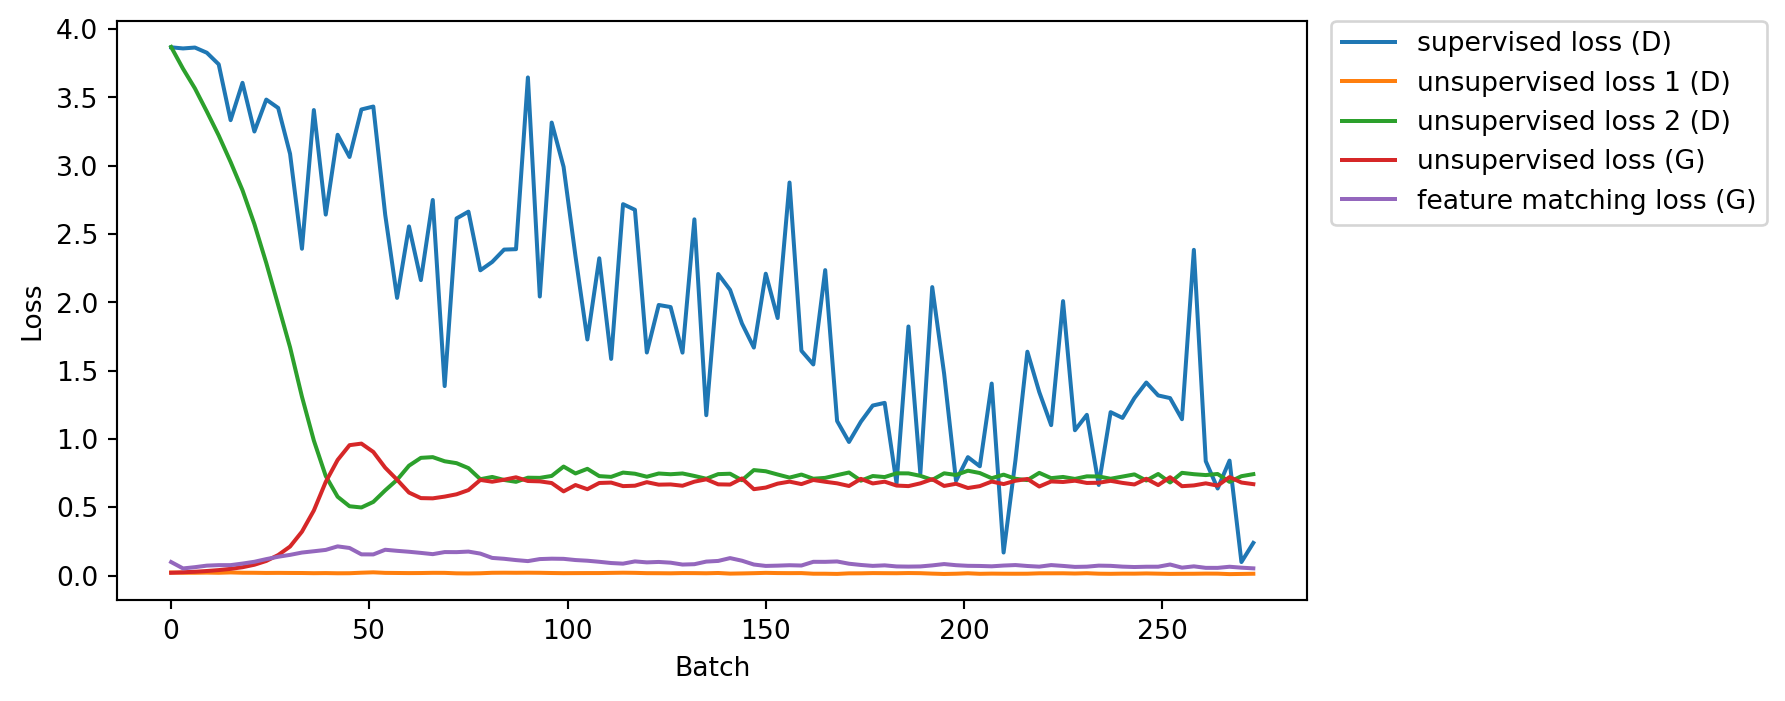

In [ ]:
import matplotlib.pyplot as plt

data = load_obj(destination_folder+'TRAIN_STATISTICS_MY_GAN-BERT_qc_label-fine_0.02_for_comparison')
labels = [
    'supervised loss (D)',
    'unsupervised loss 1 (D)',
    'unsupervised loss 2 (D)',
    'unsupervised loss (G)',
    'feature matching loss (G)']
markers = ['o','8','s','p','+']
dpi = 96*2
sample_every = 3

x = [x for x in list(range(len(data[0])))][::sample_every]
plt.figure(figsize=(8,4),dpi=dpi)
for i, l in enumerate(data):
    plt.plot(x,l[::sample_every],label=labels[i],linewidth = '1.5')

plt.ylabel('Loss')
plt.xlabel('Batch')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.savefig(destination_folder+'PLOT_TRAIN_STATISTICS_MY_GAN-BERT_qc_label-fine_0.02_for_comparison.png',transparent=True,dpi=dpi,pad_inches=0.1,bbox_inches='tight')
plt.show()